In [1]:
#initialisation for easy testing
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, fill_graph,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5

filename='brca1-testseqs.fasta'
filename2='brca1-full.fasta'
brca_seqs_work_please,names=parse_fasta_multiple(filename)
brca_seqs_long=parse_fasta_multiple_remove_n(filename2)

#print(brca_seqs_work_please)
print(brca_seqs_long[0][0:7])

#just testing if the removal of n worked!
sequence=brca_seqs_long[0][2]
print(len(set(sequence)))
contains_n = any(letter.lower() == 'n' for letter in sequence)
if contains_n:
    print("The sequence contains at least one 'n' or 'N'.")
else:
    print("The sequence does not contain 'n' or 'N'.")


for sequence in brca_seqs_long[0]:
    print(len(set(sequence)))
    print(set(sequence))

brca1_bos_taurus
brca1_canis_lupus
brca1_gallus_gallus
brca1_homo_sapiens
brca1_macaca_mulatta
brca1_mus_musculus
brca1_pan_troglodytes
brca1_rattus_norvegicus
the letter before changing is A
after, the letter is still A
the letter before changing is T
after, the letter is still T
the letter before changing is G
after, the letter is still G
the letter before changing is G
after, the letter is still G
the letter before changing is A
after, the letter is still A
the letter before changing is T
after, the letter is still T
the letter before changing is T
after, the letter is still T
the letter before changing is T
after, the letter is still T
the letter before changing is A
after, the letter is still A
the letter before changing is T
after, the letter is still T
the letter before changing is C
after, the letter is still C
the letter before changing is T
after, the letter is still T
the letter before changing is G
after, the letter is still G
the letter before changing is C
after, the lett

In [2]:
filename_n='n_containing_seqs_short.fasta'
sekk,namm=parse_fasta_multiple_remove_n(filename_n)
print(sekk)
sequence=sekk[0]
contains_n = any(letter.lower() == 'n' for letter in sequence)
if contains_n:
    print("The sequence contains at least one 'n' or 'N'.")
else:
    print("The sequence does not contain 'n' or 'N'.")

file_order_preservation='order_preservation_testing_seqs.fasta'
order_pres_seqs=parse_fasta_multiple_remove_n(file_order_preservation)
print(order_pres_seqs[0])

the letter before changing is N
after, the letter is a
the letter before changing is G
after, the letter is still G
the letter before changing is T
after, the letter is still T
the letter before changing is T
after, the letter is still T
the letter before changing is C
after, the letter is still C
the letter before changing is C
after, the letter is still C
the letter before changing is G
after, the letter is still G
the letter before changing is A
after, the letter is still A
the letter before changing is A
after, the letter is still A
the letter before changing is A
after, the letter is still A
the letter before changing is G
after, the letter is still G
the letter before changing is G
after, the letter is still G
the letter before changing is C
after, the letter is still C
the letter before changing is T
after, the letter is still T
the letter before changing is A
after, the letter is still A
the letter before changing is G
after, the letter is still G
the letter before changing is 

In [40]:
def new_sp_approxi_combi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False,layout="spring"):
    # Make a matrix to hold pairwise alignment costs for all alignment combinations!
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # Loop over all pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
            print("im aligning "+str(seq1)+" and "+ str(seq2))
            matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2,verbose=verbose))
    if verbose:
        print("Here comes the distance matrix produced by the alignments: \n")
        print(matrix)
    matrix_for_MST=matrix #copy the matrix, so that we can keep the old matrix and make a changed version to the "pseudomatrix" version
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST) #making the "pseudomatrix"
    min_span_edges=find_min_span_edges_testing(matrix_for_MST,verbose=verbose) #Run Kruskal's algorithm on the "pseudomatrix"
    if verbose:
        print("Here comes the pseudomatrix, filled out with with the edges inclued in the MST: \n")
        print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix)) # Choosing where to start traversal. I want to start at one of the nodes that is the furthest away from any other so start from a side of graph.. hmmmm...
    max_row_index = max_indices[0][0] #just choose one of them.
    if verbose:
        print("Starting key for traversal based on max_row_idex: ")
        print(max_row_index)

    #Put the nodes and the minimum spanning edges into a graph.
    G=fill_graph(min_span_edges,str(int(max_row_index)),layout) #using the max_row_index as the starting key! (an making the graph!)
    alignment_pairs,index_dict=my_traversal_simply(G,str(int(max_row_index)),verbose=verbose) #'traverse' to get alignment_pairs (pairs of sucessors and predecessors) and their position in the MSA to come (index_dict)
    if verbose:
        print("Here come your alignment pairs and the idex dict: \n")
        print(alignment_pairs)
        print(index_dict)

     # Constructing alignment M
    M: list[list[str]] = [[letter] for letter in [*seqs[int(max_row_index)]]] #make structure where evey column in the alignment is represented as a string in a list (in a list)
    cost_list = []
    #using the pairings of predecessors and successors in the alignment_pairs dict, align the strings.
    for key,value in alignment_pairs.items():
        cost = linear_C(gap_cost, score_matrix, seqs[int(value)], seqs[int(key)],verbose=verbose) #the alignment call itself :) 
        if verbose: print("\n now aligning...."+str(seqs[int(value)])+ " and "+ str(seqs[int(key)]))
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs[int(value)], seqs[int(key)], cost, score_matrix, gap_cost,verbose=verbose) #backtract to get the alignments!
        str1_nr=value #the predecessor/parent string
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str] #splitting up the alignments into elements to have the right format for the list of lists (M)
        
        A = [list(e) for e in zip(alignment1,alignment2)] #zipping the elements of the two aligned strings together pairwisely
        if verbose: print("A right now is: "+str(A))
        if verbose: print("M right now: "+str(M))
        # extend
        Mk = extend_alignment_chaos(M,str1_nr, A,index_dict,verbose=verbose) 
        M = Mk
    if verbose:
        print("Here is the alignment in full omg: \n")
        print(M)
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)
    print("Total cost of MSA:"+str(total_cost))
    return total_cost, M, matrix_for_MST,G

im aligning accgggtaaa and accgggtaaa
im aligning accgggtaaa and aacctatcca
im aligning accgggtaaa and cggacgtgga
im aligning accgggtaaa and gtatctgcat
im aligning accgggtaaa and ttattatggg
im aligning accgggtaaa and cgcacactta
im aligning accgggtaaa and agttcagggt
im aligning accgggtaaa and gcgactccgg
im aligning accgggtaaa and gtaatcccag
im aligning accgggtaaa and tgcaatctaa
im aligning aacctatcca and accgggtaaa
im aligning aacctatcca and aacctatcca
im aligning aacctatcca and cggacgtgga
im aligning aacctatcca and gtatctgcat
im aligning aacctatcca and ttattatggg
im aligning aacctatcca and cgcacactta
im aligning aacctatcca and agttcagggt
im aligning aacctatcca and gcgactccgg
im aligning aacctatcca and gtaatcccag
im aligning aacctatcca and tgcaatctaa
im aligning cggacgtgga and accgggtaaa
im aligning cggacgtgga and aacctatcca
im aligning cggacgtgga and cggacgtgga
im aligning cggacgtgga and gtatctgcat
im aligning cggacgtgga and ttattatggg
im aligning cggacgtgga and cgcacactta
im aligning 

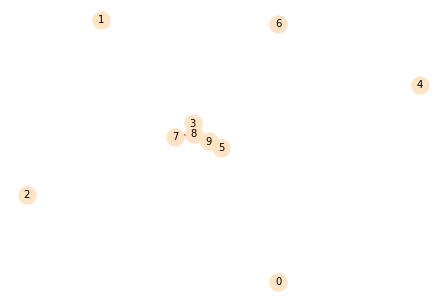

Neighbors of node 0: []
Neighbors of node 1: []
Neighbors of node 2: []
Neighbors of node 3: ['8']
Neighbors of node 4: []
Neighbors of node 5: ['9']
Neighbors of node 6: []
Neighbors of node 7: ['8']
Neighbors of node 8: ['7', '9', '3']
Neighbors of node 9: ['5', '8']
{}
Here come your alignment pairs and the idex dict: 

{}
{'6': '0'}
Here is the alignment in full omg: 

[['a'], ['g'], ['t'], ['t'], ['c'], ['a'], ['g'], ['g'], ['g'], ['t']]
Total cost of MSA:0


In [41]:
#running it!! (not ruining it hopefully :P )


cost, M, matrix_for_MST, G =new_sp_approxi_combi(order_pres_seqs[0],score_matrix,gap_cost, verbose=True)
